# Fashion-MNIST Classification using Neural Network

In this notebook, we'll build a neural network to classify Fashion-MNIST images

In [1]:
#Importing main libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Module

In [2]:
import pytorch_lightning as pl
from torchvision import transforms, datasets
from torchmetrics import Accuracy
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger


class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir

    def prepare_data(self):
        # download the dataset if it does not exist
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # define transforms
        transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
        
        if stage == 'fit' or stage is None:
            self.train_dataset = datasets.FashionMNIST(self.data_dir, download=True, train=True, transform=transform)
            train_num = len(self.train_dataset)
            indices = list(range(train_num))
            np.random.shuffle(indices)
            split = int(np.floor(0.2 * train_num))
            self.val_idx, self.train_idx = indices[:split], indices[split:]
            

        if stage == 'test' or stage is None:
            self.test_dataset = datasets.FashionMNIST(self.data_dir, download=True, train=False, transform=transform)

    def train_dataloader(self):
        train_sampler = torch.utils.data.sampler.SubsetRandomSampler(self.train_idx)
        train_dl = torch.utils.data.DataLoader(self.train_dataset, batch_size=64, sampler=train_sampler)
        return train_dl
    
    def val_dataloader(self):
        val_sampler = torch.utils.data.sampler.SubsetRandomSampler(self.val_idx)
        val_dl = torch.utils.data.DataLoader(self.train_dataset, batch_size=64, sampler=val_sampler)
        return val_dl
    
    def test_dataloader(self):
        test_dl = torch.utils.data.DataLoader(self.test_dataset, batch_size=64, shuffle=True)
        return test_dl

## Lightning Module

In [3]:
class FashionMNISTDataClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 128)),
                                                ('relu1', nn.ReLU()),
                                                ('drop1', nn.Dropout(0.25)),
                                                ('fc2', nn.Linear(128, 64)),
                                                ('relu2', nn.ReLU()),
                                                ('drop1', nn.Dropout(0.25)),
                                                ('output', nn.Linear(64, 10)),
                                                ('logsoftmax', nn.LogSoftmax(dim=1))]))
        self.loss_fn = nn.NLLLoss()

        self.val_accuracy = Accuracy(task='multiclass', num_classes=10)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=10)

        #Will be used for storing the average losses after each epoch
        self.train_losses =[]
        self.test_losses = []

        #Will be used for storing the losses after each step
        self.temp_training_losses = []
        self.temp_validation_losses = []

        
    def forward(self, x):
        x = self.network(x)
        return x
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.view(images.shape[0], -1)
        out = self.forward(images)
        loss = self.loss_fn(out, labels)
        self.log('train_loss', loss, prog_bar=True)
        self.temp_training_losses.append(loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.view(images.shape[0], -1)
        out = self.forward(images)
        loss = self.loss_fn(out, labels)
        preds = torch.argmax(out, dim=1)
        self.val_accuracy.update(preds, labels)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_accuracy, prog_bar=True)

        self.temp_validation_losses.append(loss)
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        images = images.view(images.shape[0], -1)
        out = self.forward(images)
        loss = self.loss_fn(out, labels)
        preds = torch.argmax(out, dim=1)
        self.test_accuracy.update(preds, labels)
        
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_accuracy, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.003)
        return optimizer
    
    def on_train_epoch_end(self, *args, **kwargs):        
        train_loss_mean = torch.stack(self.temp_training_losses).mean()
        self.temp_training_losses = []
        self.train_losses.append(train_loss_mean)


    def on_validation_epoch_end(self, *arg, **kwargs):
        val_loss_mean = torch.stack(self.temp_validation_losses).mean()
        self.temp_validation_losses = []
        self.test_losses.append(val_loss_mean)

    def plot_losses(self):
        train_losses_tensor = torch.tensor(self.train_losses, dtype=torch.float32)
        test_losses_tensor = torch.tensor(self.test_losses, dtype=torch.float32)
        
        plt.plot(train_losses_tensor.detach().numpy(), label='train-loss')
        plt.plot(test_losses_tensor.detach().numpy(), label='val-loss')
        plt.legend()
        plt.show()

In [4]:
#Initializing the data module and the model
dm = FashionMNISTDataModule()
model = FashionMNISTDataClassifier()

print(model)

FashionMNISTDataClassifier(
  (network): Sequential(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (relu1): ReLU()
    (drop1): Dropout(p=0.25, inplace=False)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (relu2): ReLU()
    (output): Linear(in_features=64, out_features=10, bias=True)
    (logsoftmax): LogSoftmax(dim=1)
  )
  (loss_fn): NLLLoss()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)


## Train the network

In [5]:
trainer = pl.Trainer(max_epochs=1, callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir="logs/"))
def train_validate(model, n_epochs):
    trainer = pl.Trainer(max_epochs=n_epochs)
    #Training
    trainer.fit(model, dm)

    #Printing the losses
    model.plot_losses()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


100%|██████████| 26421880/26421880 [00:22<00:00, 1169192.66it/s]


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 430548.96it/s]


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3040610.70it/s]


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw


Missing logger folder: c:\Users\mosta\OneDrive\Desktop\fashion-mnist-classification\lightning_logs



  | Name          | Type               | Params
-----------------------------------------------------
0 | network       | Sequential         | 109 K 
1 | loss_fn       | NLLLoss            | 0     
2 | val_accuracy  | MulticlassAccuracy | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 26.81it/s]

C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 24: 100%|██████████| 750/750 [00:24<00:00, 31.22it/s, v_num=0, train_loss=0.309, val_loss=0.324, val_acc=0.887] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 750/750 [00:24<00:00, 31.20it/s, v_num=0, train_loss=0.309, val_loss=0.324, val_acc=0.887]


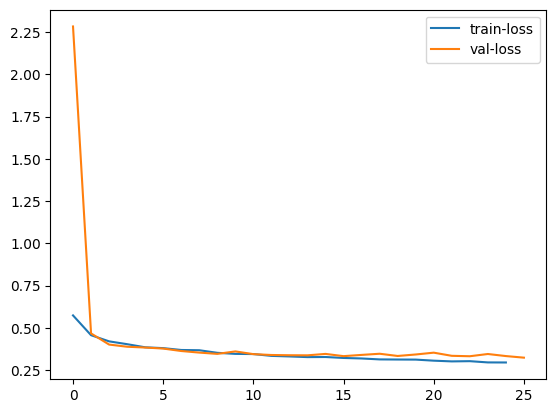

In [6]:
# Train and validate
train_validate(model, n_epochs=25)

## Validate on test set

In [7]:
# Validate
trainer.test(model, datamodule=dm)

Missing logger folder: logs/lightning_logs
C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
C:\Users\mosta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 74.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8770999908447266
        test_loss           0.34952521324157715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.34952521324157715, 'test_acc': 0.8770999908447266}]

### Predict a single image

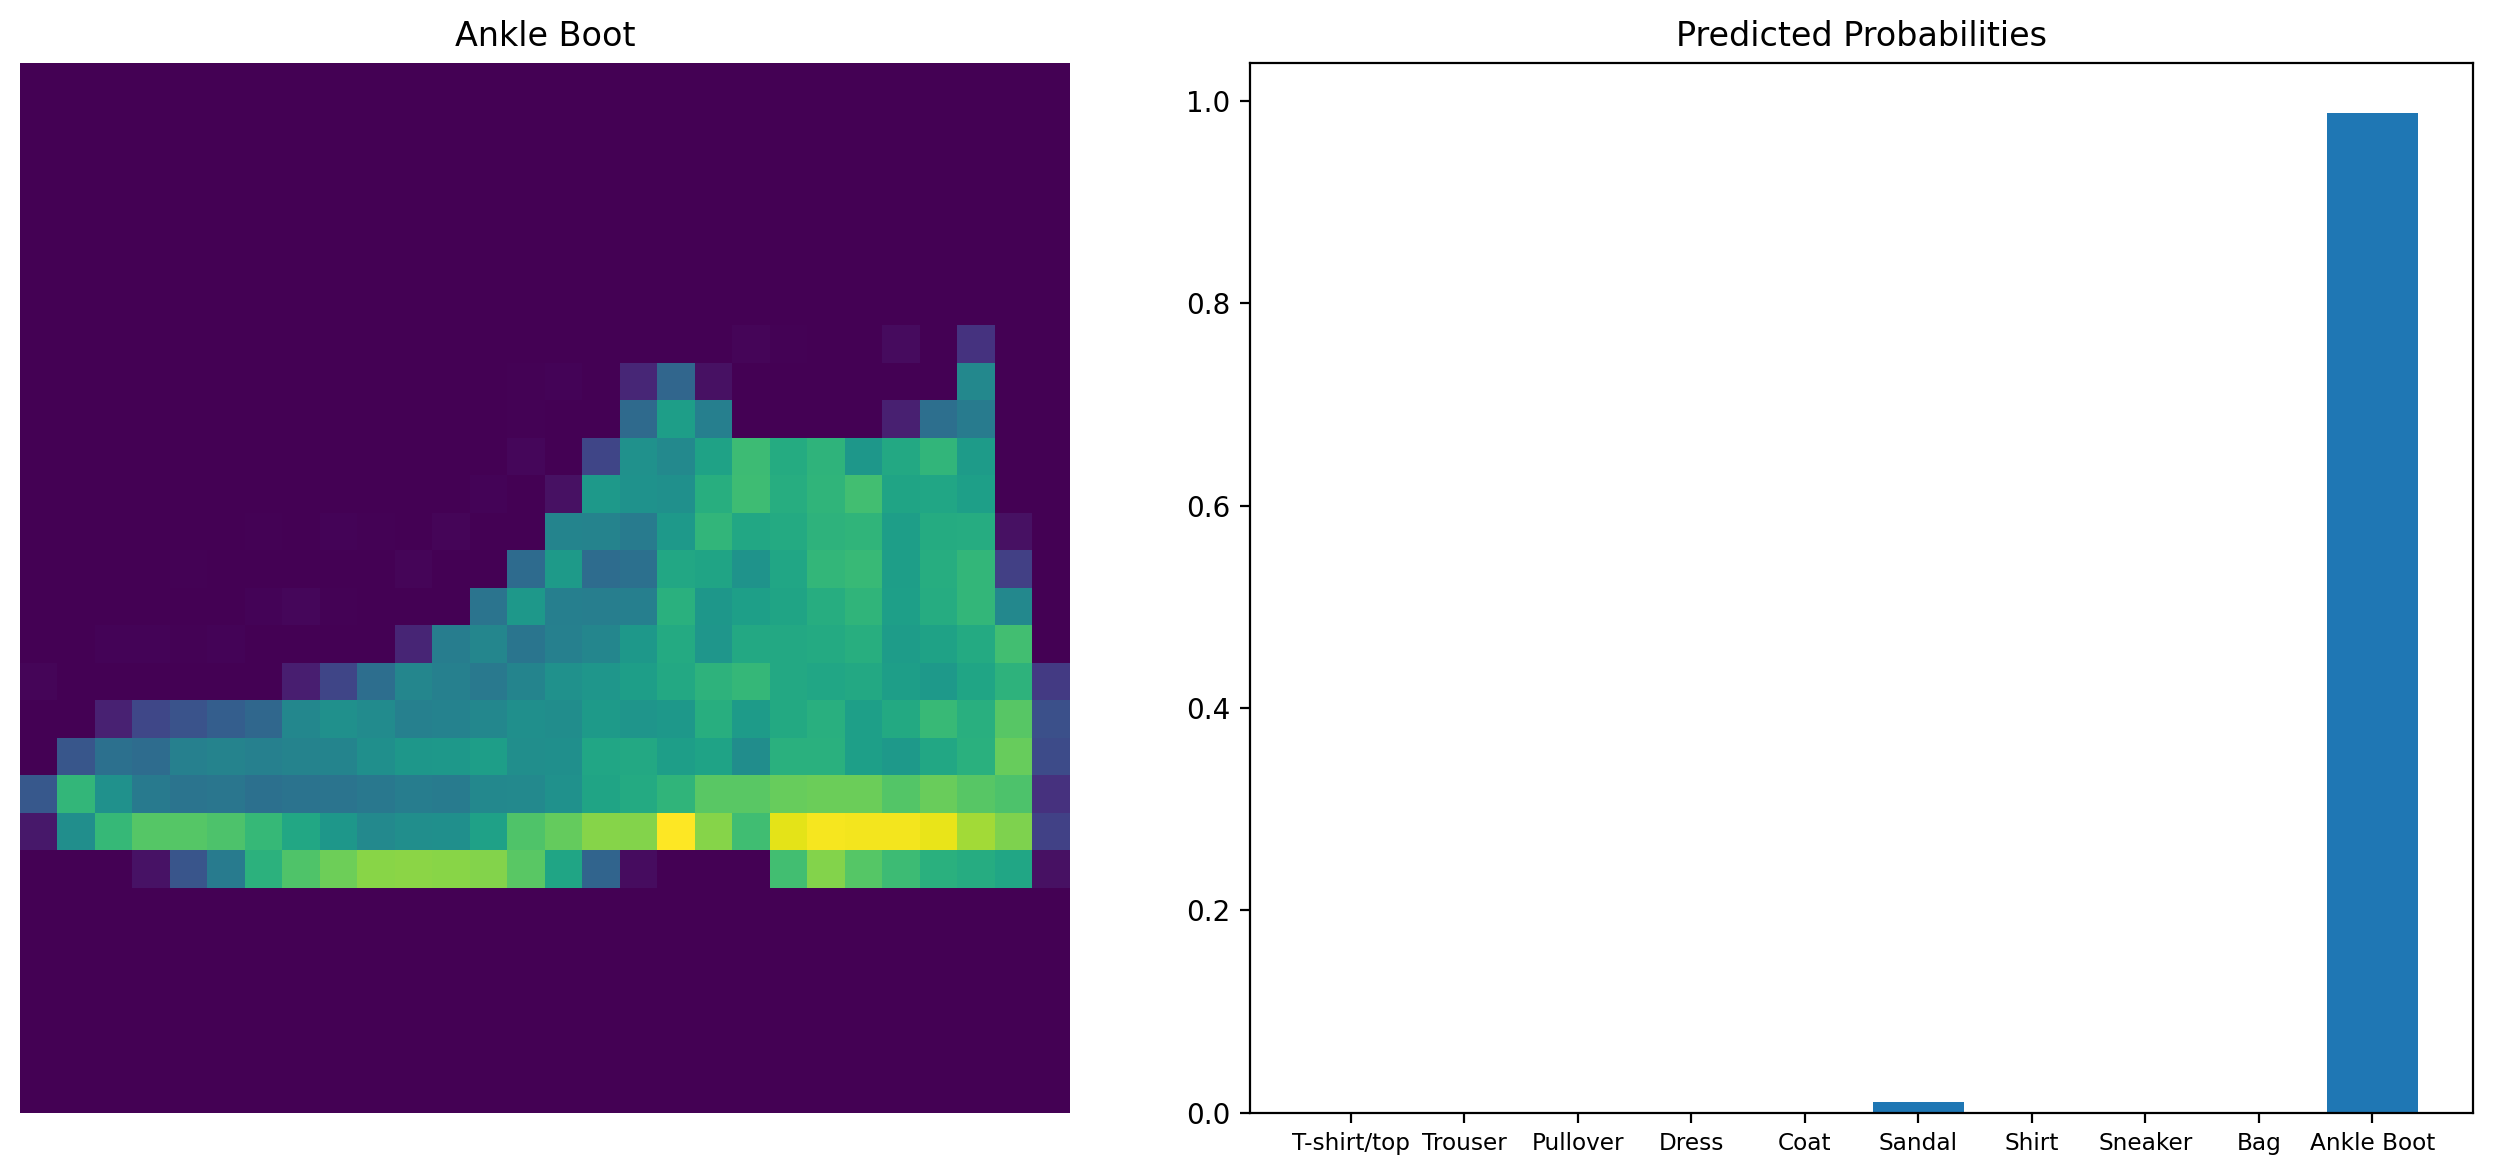

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

index = 0
img, label = dm.test_dataset[index]

label = torch.tensor(label) if not isinstance(label, torch.Tensor) else label

img = img.view(img.shape[0], -1)

# Calculate the class probabilities (softmax) for img
proba = torch.exp(model(img))

# Plot the image and probabilities
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
fig, (ax1, ax2) =  plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
ax1.axis('off')
ax1.imshow(img.squeeze().reshape(28, 28))
ax1.set_title(desc[label.item()])
ax2.bar(range(10), proba.detach().cpu().numpy().squeeze())
ax2.set_xticks(range(10))
ax2.set_xticklabels(desc, size='small')
ax2.set_title('Predicted Probabilities')
plt.tight_layout()

## More powerful model

In [9]:
# Redefine network with dropout layers in between
model.network = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 392)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('fc12', nn.Linear(392, 196)),
                                       ('relu2', nn.ReLU()),
                                       ('drop2', nn.Dropout(0.25)),
                                       ('fc3', nn.Linear(196, 98)),
                                       ('relu3', nn.ReLU()),
                                       ('drop3', nn.Dropout(0.25)),                                       
                                       ('fc4', nn.Linear(98, 49)),
                                       ('relu4', nn.ReLU()),
                                       ('output', nn.Linear(49, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))

In [10]:
model

FashionMNISTDataClassifier(
  (network): Sequential(
    (fc1): Linear(in_features=784, out_features=392, bias=True)
    (relu1): ReLU()
    (drop1): Dropout(p=0.25, inplace=False)
    (fc12): Linear(in_features=392, out_features=196, bias=True)
    (relu2): ReLU()
    (drop2): Dropout(p=0.25, inplace=False)
    (fc3): Linear(in_features=196, out_features=98, bias=True)
    (relu3): ReLU()
    (drop3): Dropout(p=0.25, inplace=False)
    (fc4): Linear(in_features=98, out_features=49, bias=True)
    (relu4): ReLU()
    (output): Linear(in_features=49, out_features=10, bias=True)
    (logsoftmax): LogSoftmax(dim=1)
  )
  (loss_fn): NLLLoss()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)


  | Name          | Type               | Params
-----------------------------------------------------
0 | network       | Sequential         | 409 K 
1 | loss_fn       | NLLLoss            | 0     
2 | val_accuracy  | MulticlassAccuracy | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
409 K     Trainable params
0         Non-trainable params
409 K     Total params
1.638     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 750/750 [00:30<00:00, 24.57it/s, v_num=0, train_loss=0.575, val_loss=0.492, val_acc=0.821]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 750/750 [00:30<00:00, 24.53it/s, v_num=0, train_loss=0.575, val_loss=0.492, val_acc=0.821]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params
-----------------------------------------------------
0 | network       | Sequential         | 409 K 
1 | loss_fn       | NLLLoss            | 0     
2 | val_accuracy  | MulticlassAccuracy | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
409 K     Trainable params
0         Non-trainable params
409 K     Total params
1.638     Total estimated model params size (MB)


Epoch 34: 100%|██████████| 750/750 [00:34<00:00, 21.61it/s, v_num=1, train_loss=0.389, val_loss=0.348, val_acc=0.882] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 750/750 [00:34<00:00, 21.58it/s, v_num=1, train_loss=0.389, val_loss=0.348, val_acc=0.882]


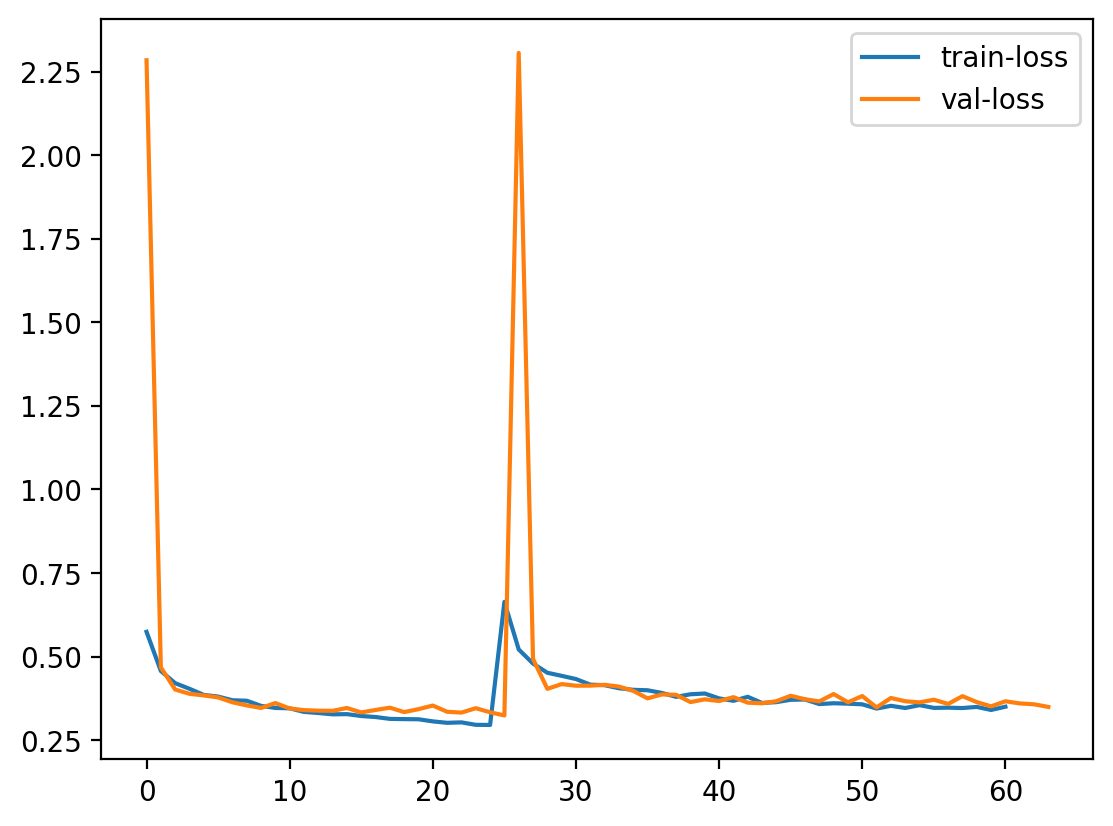

In [11]:
#Fitting the model to trainer
trainer.fit(model, dm)

# Train and validate again with new architecture
train_validate(model, n_epochs=35)

## Validate on test set

In [12]:
# Validate
trainer.test(model, datamodule=dm)

Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 63.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8718000054359436
        test_loss           0.3801654279232025
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3801654279232025, 'test_acc': 0.8718000054359436}]